# **Load Dataset**

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# === Transformasi untuk TRAIN (pakai augmentasi) ===
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # crop random
    transforms.RandomHorizontalFlip(),                  # flip kiri-kanan
    transforms.RandomRotation(10),                      # rotasi ±10 derajat
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)), # geser posisi
    transforms.RandomErasing(p=0.2, scale=(0.02,0.1))        # hapus sebagian pixel

])

# === Transformasi untuk VALIDASI & TEST (tanpa augmentasi) ===
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# Load full train dataset
train_data_full = datasets.ImageFolder("/kaggle/input/dermnet/train", transform=train_tf)

# Split train jadi train + val (misal 80:20)
train_size = int(0.8 * len(train_data_full))
val_size = len(train_data_full) - train_size

train_data, val_data = random_split(train_data_full, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Test data tetap
test_data = datasets.ImageFolder("/kaggle/input/dermnet/test", transform=eval_tf)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


# **Load Pretrained ResNet**

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights

# Pretrained ResNet18
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze semua layer dulu
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer3 dan layer4 (block terakhir ResNet18)
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

# Ganti fully connected layer terakhir sesuai jumlah kelas
num_classes = len(train_data_full.classes)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.35),
    nn.Linear(128, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 101MB/s] 


# **Loss & Optimizer**

In [3]:
from torch.optim.lr_scheduler import OneCycleLR
import torch
from torch.optim import AdamW

num_epochs = 50

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,                 # learning rate maksimum selama cycle
    steps_per_epoch=len(train_loader),  # jumlah batch per epoch
    epochs=num_epochs           # total epoch training
)



# **Training Loop**

Epoch 1: Train Loss=2.9177, Train Acc=18.38% | Val Loss=2.6761, Val Acc=27.28%
Epoch 2: Train Loss=2.6022, Train Acc=29.82% | Val Loss=2.4515, Val Acc=33.87%
Epoch 3: Train Loss=2.4436, Train Acc=34.42% | Val Loss=2.3548, Val Acc=36.99%
Epoch 4: Train Loss=2.3383, Train Acc=38.39% | Val Loss=2.2571, Val Acc=39.88%
Epoch 5: Train Loss=2.2601, Train Acc=40.71% | Val Loss=2.2110, Val Acc=41.48%
Epoch 6: Train Loss=2.2155, Train Acc=41.93% | Val Loss=2.2266, Val Acc=40.71%
Epoch 7: Train Loss=2.1837, Train Acc=43.27% | Val Loss=2.2465, Val Acc=39.91%
Epoch 8: Train Loss=2.1619, Train Acc=44.11% | Val Loss=2.2202, Val Acc=41.68%
Epoch 9: Train Loss=2.1329, Train Acc=44.40% | Val Loss=2.2666, Val Acc=39.40%
Epoch 10: Train Loss=2.1147, Train Acc=45.73% | Val Loss=2.1814, Val Acc=42.87%
Epoch 11: Train Loss=2.0900, Train Acc=46.95% | Val Loss=2.1086, Val Acc=45.12%
Epoch 12: Train Loss=2.0417, Train Acc=48.05% | Val Loss=2.2309, Val Acc=42.26%
Epoch 13: Train Loss=2.0259, Train Acc=49.12% | V

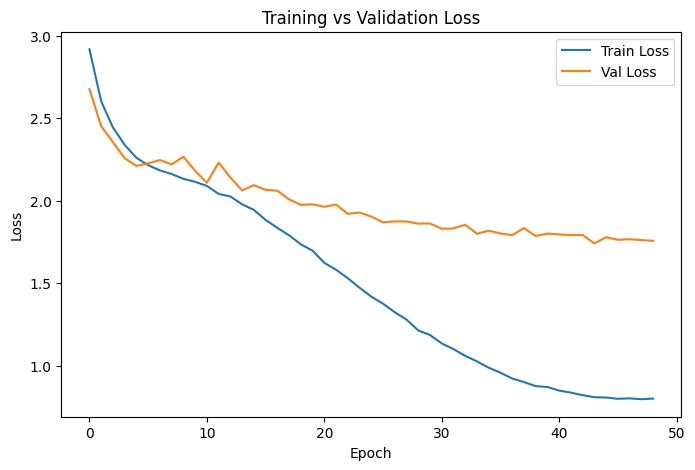

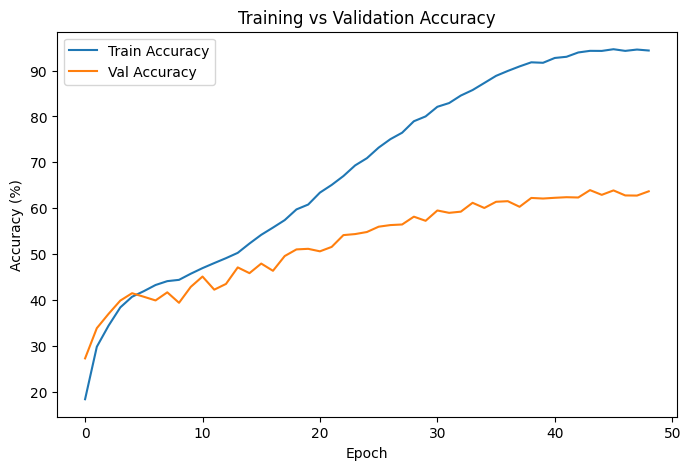

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# --- Label Smoothing ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_loss = float("inf")
patience = 5
trigger_times = 0

for epoch in range(num_epochs):  # misal 20 epoch
    # === TRAINING ===
    model.train()
    train_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        scheduler.step()   # ← tambahkan ini untuk OneCycleLR

        train_loss += loss.item() * x.size(0)
        _, pred = out.max(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    epoch_train_loss = train_loss / total
    epoch_train_acc  = 100 * correct / total

    # === VALIDATION ===
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            val_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            val_correct += (pred == y).sum().item()
            val_total += y.size(0)

    epoch_val_loss = val_loss / val_total
    epoch_val_acc  = 100 * val_correct / val_total

    # Simpan history
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.2f}% | "
          f"Val Loss={epoch_val_loss:.4f}, Val Acc={epoch_val_acc:.2f}%")



    
    # Early Stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")  # simpan model terbaik
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("⏹️ Early stopping!")
            break


import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


Test Loss: 1.8488 | Test Accuracy: 60.74%


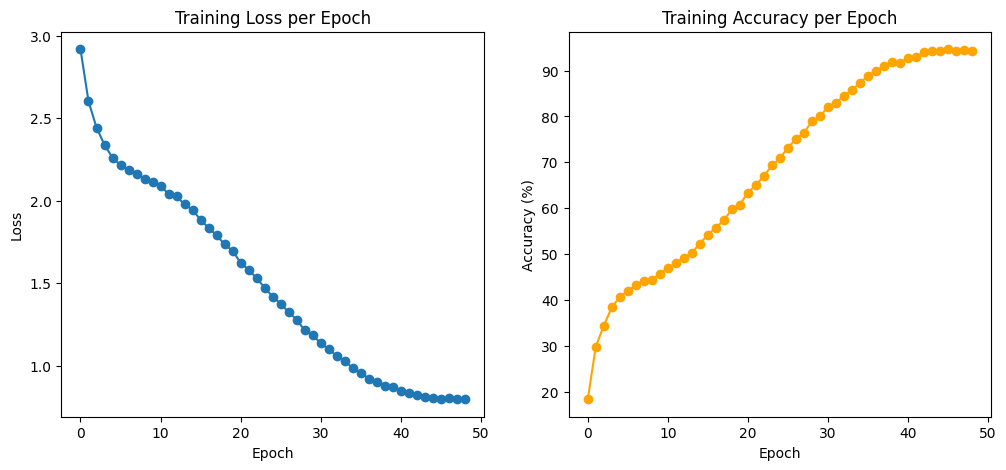

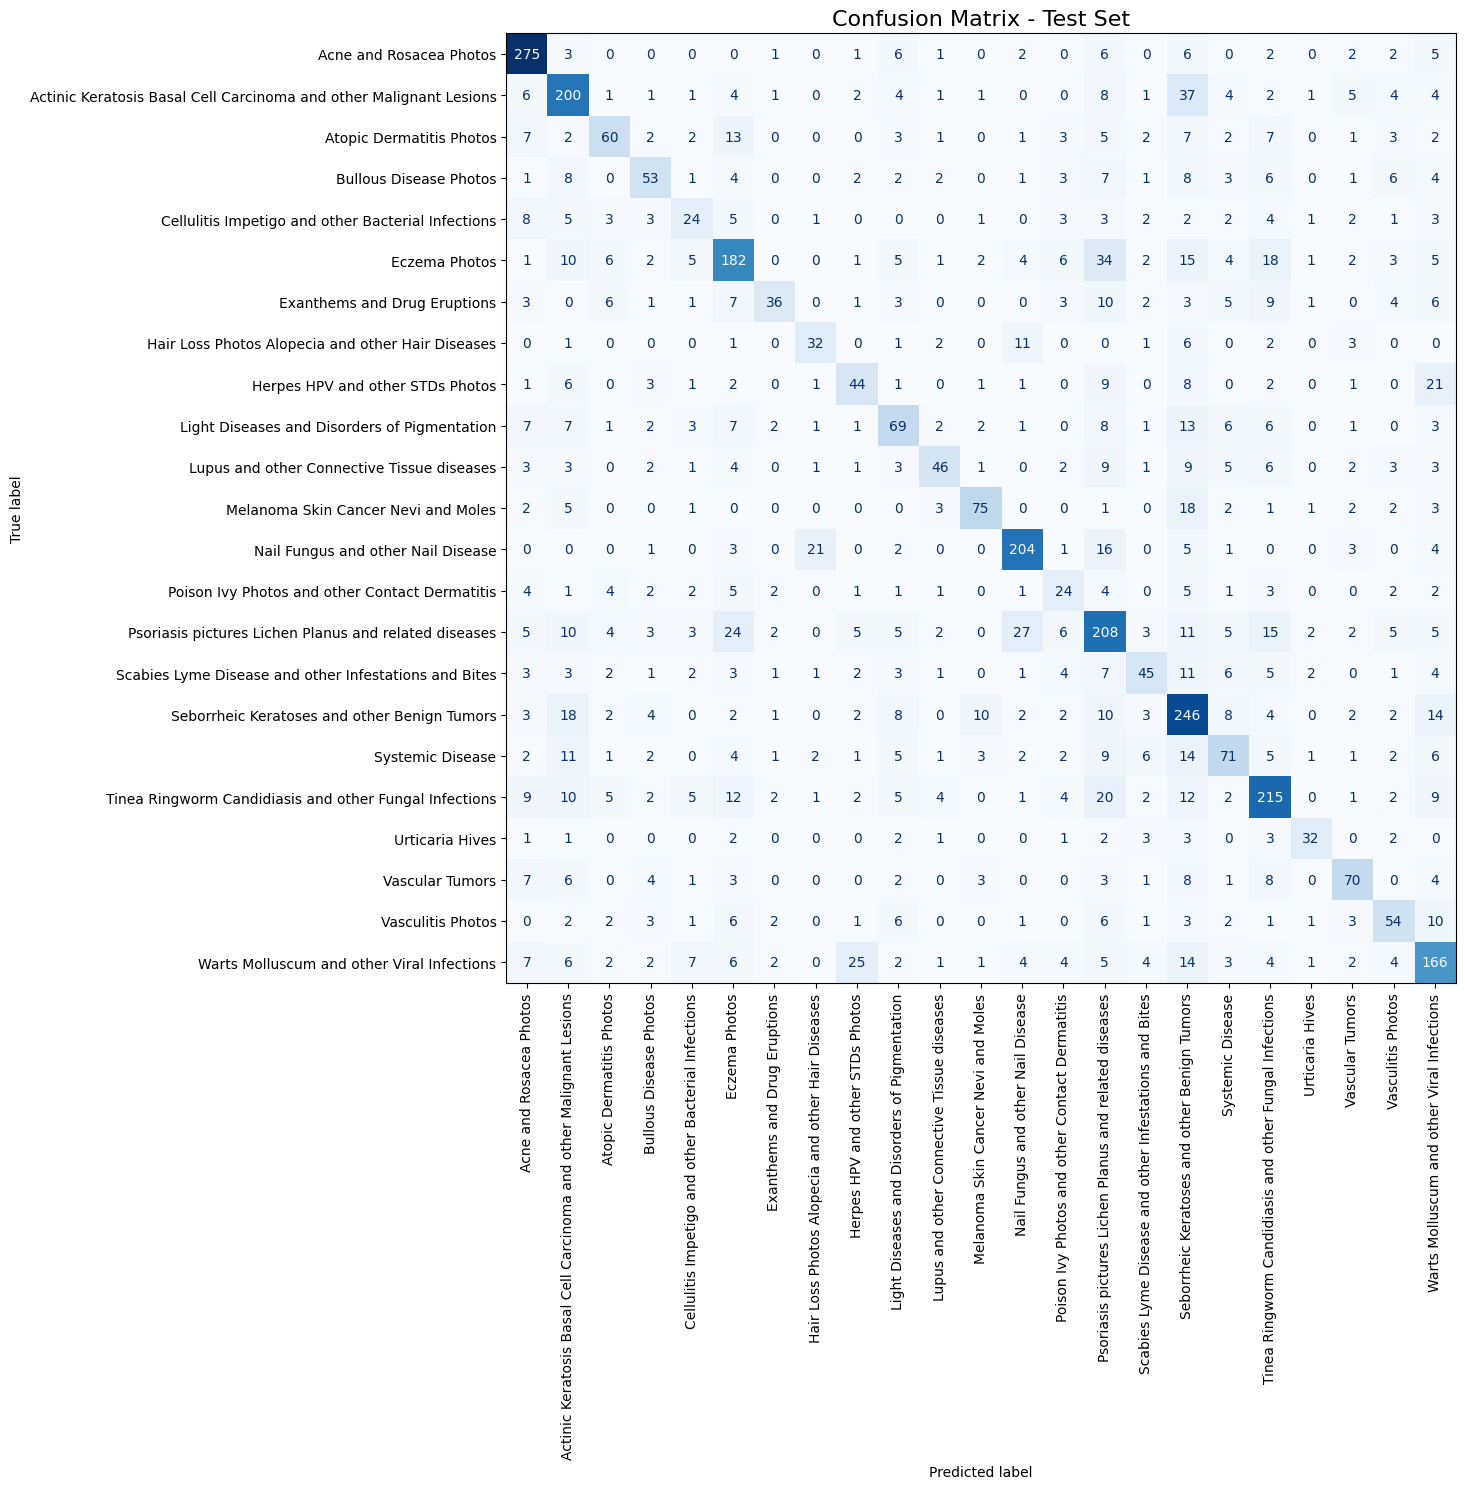

In [5]:
model.eval()
correct, total = 0, 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Hitung loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        # Hitung akurasi
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Rata-rata test loss
epoch_test_loss = test_loss / total
test_acc = 100 * correct / total

print(f"Test Loss: {epoch_test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# Plot Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, marker='o', color='orange')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(15,15))  # bikin figure besar
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=train_data_full.classes)

disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, ax=ax, colorbar=False)
plt.title("Confusion Matrix - Test Set", fontsize=16)
plt.tight_layout()
plt.show()



Jumlah kelas: 23
Daftar kelas: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']

Hasil prediksi untuk: /kaggle/input/skin-predict/Predict1_

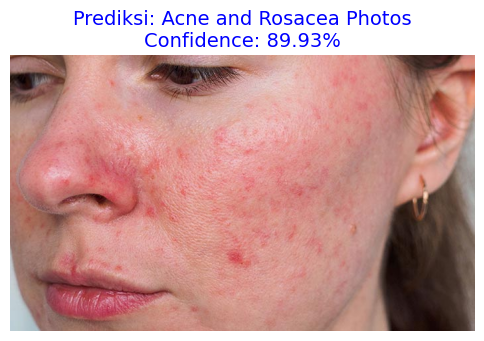

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets

# -----------------------------
# Path penting (ubah sesuai lokasi)
# -----------------------------
TRAIN_DIR     = "/kaggle/input/dermnet/train"   # untuk ambil nama kelas
WEIGHTS_PATH  = "best_model.pth"                # bobot hasil training
IMAGE_PATH    = "/kaggle/input/skin-predict/Predict1_rosacea.jpg"                   # gambar baru yang mau diprediksi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Ambil daftar kelas (23 kategori)
# -----------------------------
class_names = datasets.ImageFolder(TRAIN_DIR).classes

print("Jumlah kelas:", len(class_names))
print("Daftar kelas:", class_names)

# -----------------------------
# Transform evaluasi
# -----------------------------
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# -----------------------------
# Bangun ulang model sama persis
# -----------------------------
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze & unfreeze sesuai training
for p in model.parameters():
    p.requires_grad = False
for p in model.layer3.parameters():
    p.requires_grad = True
for p in model.layer4.parameters():
    p.requires_grad = True

# Ganti FC
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.35),
    nn.Linear(128, num_classes)
)

# Load bobot hasil training
state = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(state)
model = model.to(device)
model.eval()

# -----------------------------
# Prediksi Top-1 + tampilkan gambar
# -----------------------------
def predict_top1_show(img_path):
    img = Image.open(img_path).convert("RGB")
    x = eval_tf(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(x)
        probs = torch.softmax(outputs, dim=1)
        conf, pred_class = torch.max(probs, 1)

    label = class_names[pred_class.item()]
    confidence = conf.item() * 100

    # Print teks di terminal
    print(f"\nHasil prediksi untuk: {img_path}")
    print(f"Prediksi: {label} ({confidence:.2f}%)")

    # Tampilkan gambar dengan matplotlib + label di atas
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediksi: {label}\nConfidence: {confidence:.2f}%", fontsize=14, color="blue")
    plt.show()

# -----------------------------
# Coba prediksi 1 gambar
# -----------------------------
predict_top1_show(IMAGE_PATH)
